In [17]:

import pandas as pd 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np



df_train = pd.read_csv("../DATA/processed/synthetic_sales_expanded.csv")
df_train.head(2)

df_train['year'] = pd.to_datetime(df_train['DATE']).dt.year
df_train['month'] = pd.to_datetime(df_train['DATE']).dt.month
df_train['day'] = pd.to_datetime(df_train['DATE']).dt.day


df_train_less_500k = df_train[df_train['UNITARY_PRICE']<500]




In [26]:
df_train_less_500k["REVENUE"] = df_train_less_500k["UNITARY_PRICE"] * df_train_less_500k["QUANTITY_SOLD"]


/tmp/ipykernel_9488/879081172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_less_500k["REVENUE"] = df_train_less_500k["UNITARY_PRICE"] * df_train_less_500k["QUANTITY_SOLD"]


In [19]:
# Generate a slope for each unique product in order of appearance

intercept = 40
error_std = 5
product_slopes = pd.Series(
    np.random.uniform(-1.2, -0.1, size = df_train_less_500k['PRODUTO'].nunique()),
    index=df_train_less_500k['PRODUTO'].unique()
)

# Generate noise for each product group (aligned with original DataFrame)
noise = df_train_less_500k.groupby('PRODUTO', sort=False)['PRODUTO'].transform(
    lambda x: np.random.normal(60, 15, len(x))
)

# Vectorized computation of QUANTITY_SOLD with non-negativity constraint
df_train_less_500k['QUANTITY_SOLD'] = np.maximum(
    0,  # Ensure quantity sold is at least 0
    np.round(  # Round to nearest integer
        intercept 
        + df_train_less_500k['PRODUTO'].map(product_slopes) * df_train_less_500k['UNITARY_PRICE'] 
        + noise
    )
)

/tmp/ipykernel_9488/2833386831.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_less_500k['QUANTITY_SOLD'] = np.maximum(


In [28]:
df_train_less_500k_positive_sales = df_train_less_500k[df_train_less_500k['QUANTITY_SOLD']>0]

In [58]:
df_train_grouped = df_train_less_500k_positive_sales.groupby(["PRODUTO","PMC Sem Imposto","month","year","LABORATÓRIO", "CLASSE TERAPÊUTICA","TARJA"]).agg(
    UNITARY_PRICE_MEAN=("UNITARY_PRICE", "mean"),
    QUANTITY_SOLD_TOTAL=("QUANTITY_SOLD", "sum"),
    TOTAL_REVENUE=("REVENUE", "sum")).reset_index()

df_train_grouped[df_train_grouped['PRODUTO'] == 'TOLREST']

,PRODUTO,PMC Sem Imposto,month,year,LABORATÓRIO,CLASSE TERAPÊUTICA,TARJA,UNITARY_PRICE_MEAN,QUANTITY_SOLD_TOTAL,TOTAL_REVENUE
317285,TOLREST,37.99,1,2023,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,44.033405,2637.0,116077.634131
317286,TOLREST,37.99,1,2024,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,43.192665,2615.0,112793.808679
317287,TOLREST,37.99,2,2023,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,42.241620,2233.0,94178.266219
317288,TOLREST,37.99,2,2024,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,43.136816,2287.0,98709.856483
317289,TOLREST,37.99,3,2023,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,43.660535,2701.0,117835.224459
...,...,...,...,...,...,...,...,...,...,...
317541,TOLREST,264.50,10,2024,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,- (*),301.050340,9.0,2716.031317
317542,TOLREST,264.50,11,2023,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,- (*),272.599428,2.0,545.198856
317543,TOLREST,264.50,11,2024,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,- (*),273.806551,13.0,3637.134593
317544,TOLREST,264.50,12,2023,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,- (*),302.246977,10.0,3010.954758


In [56]:
df_train_grouped.sample(20)

,PRODUTO,PMC Sem Imposto,month,year,LABORATÓRIO,CLASSE TERAPÊUTICA,TARJA,UNITARY_PRICE_MEAN,QUANTITY_SOLD_TOTAL,TOTAL_REVENUE
317337,TOLREST,74.75,3,2023,ACHE LABORATORIOS FARMACEUTICOS SA,N6A4 - ANTIDEPRESSIVOS SSRI,Tarja Vermelha sob restrição,86.624707,2099.0,181300.493111
320653,TRAVOPROSTA,78.59,12,2024,SANOFI MEDLEY FARMACÊUTICA LTDA.,S1E2 - PREPARAÇÕES ANTIGLAUCOMAS E MIÓTICAS TÓ...,Tarja Vermelha,91.485244,2428.0,221610.525008
180445,IBUPROTRAT,25.35,6,2024,NATULAB LABORATORIO S.A,N2B2 - ANALGÉSICOS NÃO NARCÓTICOS E ANTIPIRÉTI...,- (*),31.830509,1907.0,60677.867456
81003,CLORIDRATO DE DONEPEZILA,217.62,6,2024,EMS S/A,"N7D1 - PRODUTOS ANTIALZHEIMER, INIBIDORES DA C...",Tarja Vermelha sob restrição,246.435461,544.0,131038.466426
1991,ACERTANLO,48.25,12,2024,LABORATORIOS SERVIER DO BRASIL LTDA,C9B3 - INIBIDORES DA ECA ASSOCIADOS A ANTAGONI...,Tarja Vermelha,61.960799,2562.0,157905.122778
221797,MONAX,89.36,1,2024,EUROFARMA LABORATORIOS S.A.,R1A1 - CORTICOSTERÓIDES NASAIS SEM ANTIINFECCI...,Tarja Vermelha,101.521816,2351.0,238239.289290
311854,TAVAGRAN,256.94,8,2024,LEGRAND PHARMA INDUSTRIA FARMACEUTICA LTDA,J1G1 - FLUORQUINOLONAS ORAIS,Tarja Vermelha sob restrição,301.661037,1373.0,411960.706962
17674,AMITIZA,187.05,12,2024,TAKEDA PHARMA LTDA.,"A06A9 - OUTROS LAXANTES, INCLUINDO ASSOCIAÇÕES",Tarja Vermelha,223.829173,181.0,40042.274032
279682,QUINOFLOX,67.55,10,2023,BIOLAB SANUS FARMACEUTICA LTDA,J1G1 - FLUORQUINOLONAS ORAIS,Tarja Vermelha sob restrição,76.688306,2224.0,169475.412556
297982,SINVASTATINA,10.63,5,2024,MULTILAB INDUSTRIA E COMERCIO DE PRODUTOS FARM...,"C10A1 - ESTATINAS, INIBIDORES DA REDUTASE HMG-CoA",Tarja Vermelha,12.010434,2741.0,32805.855466


/tmp/ipykernel_9488/4160023069.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_product['PREDICTED_SALES'] = model.predict(sm.add_constant(df_product['UNITARY_PRICE_MEAN']))


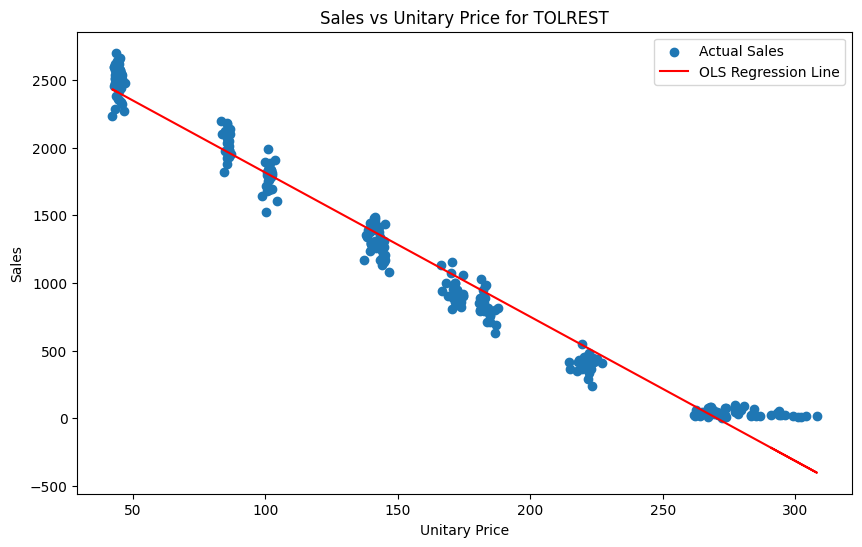

In [59]:
#Choose one product, for example, 'BAYCUTEN N'

product_name = 'TOLREST'
df_product = df_train_grouped[df_train_grouped['PRODUTO'] == product_name]

# Fit an OLS model
model = sm.OLS(df_product['QUANTITY_SOLD_TOTAL'], sm.add_constant(df_product['UNITARY_PRICE_MEAN'])).fit()

# Predict the values
df_product['PREDICTED_SALES'] = model.predict(sm.add_constant(df_product['UNITARY_PRICE_MEAN']))

# Plot the scatterplot with the regression line
plt.figure(figsize=(10, 6))
plt.scatter(df_product['UNITARY_PRICE_MEAN'], df_product['QUANTITY_SOLD_TOTAL'], label='Actual Sales')
plt.plot(df_product['UNITARY_PRICE_MEAN'], df_product['PREDICTED_SALES'], color='red', label='OLS Regression Line')
plt.xlabel('Unitary Price')
plt.ylabel('Sales')
plt.title(f'Sales vs Unitary Price for {product_name}')
plt.legend()
plt.show()

                             OLS Regression Results                            
Dep. Variable:     QUANTITY_SOLD_TOTAL   R-squared:                       0.459
Model:                             OLS   Adj. R-squared:                  0.459
Method:                  Least Squares   F-statistic:                     1756.
Date:                 Thu, 30 Jan 2025   Prob (F-statistic):          2.04e-278
Time:                         07:50:11   Log-Likelihood:                -16848.
No. Observations:                 2072   AIC:                         3.370e+04
Df Residuals:                     2070   BIC:                         3.371e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3327.4

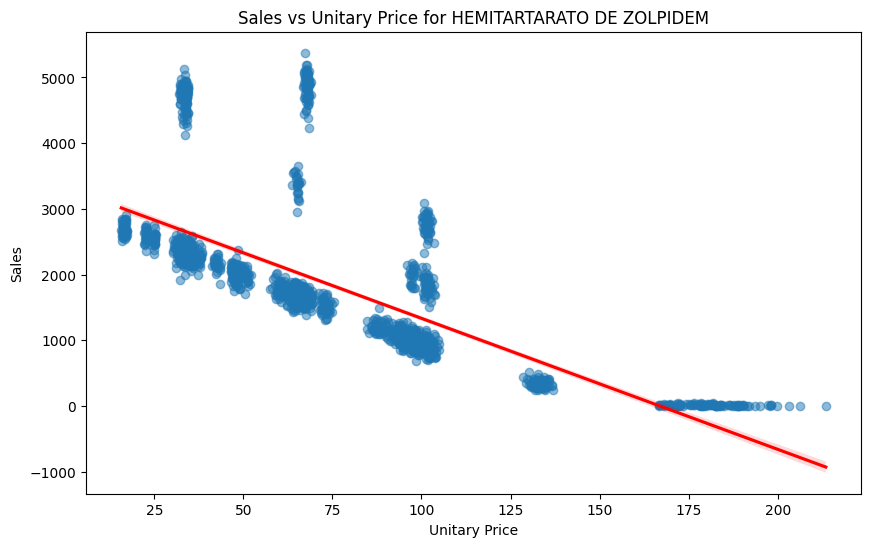

In [45]:
import seaborn as sns
product_name = 'HEMITARTARATO DE ZOLPIDEM'
df_product = df_train_grouped[df_train_grouped['PRODUTO'] == product_name]

# Check if data exists
if df_product.empty:
    raise ValueError(f"No data found for product: {product_name}")

# Fit OLS model
X = sm.add_constant(df_product['UNITARY_PRICE_MEAN'])
model = sm.OLS(df_product['QUANTITY_SOLD_TOTAL'], X).fit()

# Print model diagnostics
print(model.summary())

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(
    x=df_product['UNITARY_PRICE_MEAN'],
    y=df_product['QUANTITY_SOLD_TOTAL'],
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)
plt.title(f'Sales vs Unitary Price for {product_name}')
plt.xlabel('Unitary Price')
plt.ylabel('Sales')
plt.show()

/tmp/ipykernel_9488/3567461902.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['PREDICTED_SALES'] = model.predict(X)
/tmp/ipykernel_9488/3567461902.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['PREDICTED_SALES'] = model.predict(X)


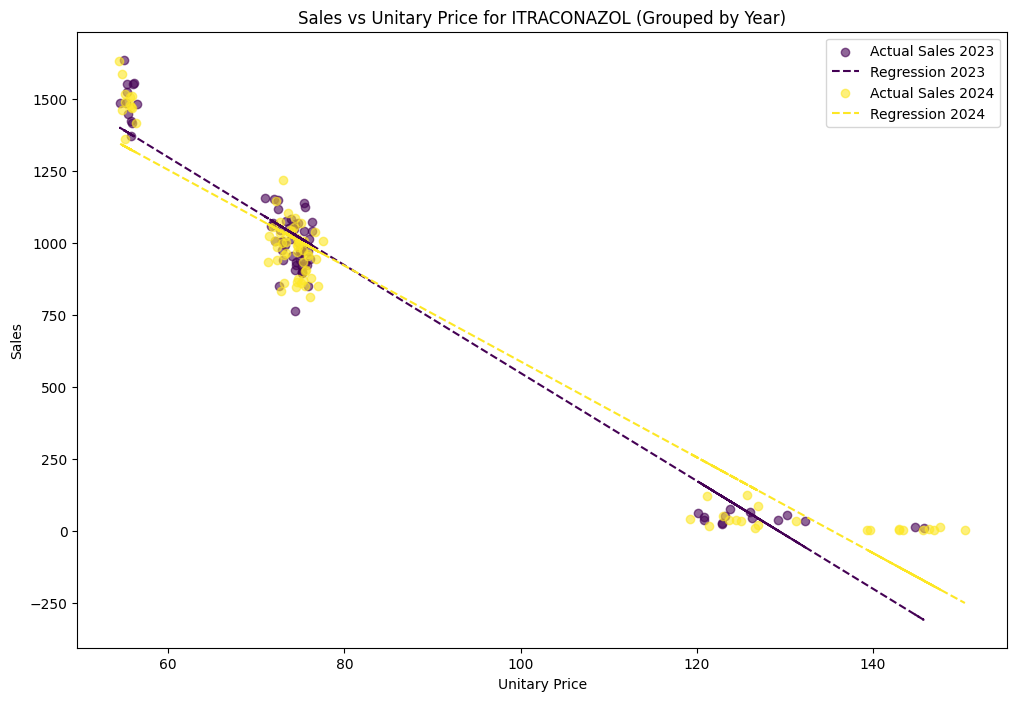


Year 2023 Regression Summary:
                             OLS Regression Results                            
Dep. Variable:     QUANTITY_SOLD_TOTAL   R-squared:                       0.945
Model:                             OLS   Adj. R-squared:                  0.945
Method:                  Least Squares   F-statistic:                     1247.
Date:                 Thu, 30 Jan 2025   Prob (F-statistic):           3.27e-47
Time:                         07:57:09   Log-Likelihood:                -450.53
No. Observations:                   74   AIC:                             905.1
Df Residuals:                       72   BIC:                             909.7
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Assuming your data has a 'YEAR' column. If not, create it from a date column:
# df_train_grouped['YEAR'] = pd.to_datetime(df_train_grouped['DATE']).dt.year

product_name = 'ITRACONAZOL'
df_product = df_train_grouped[df_train_grouped['PRODUTO'] == product_name]

# Check if data exists
if df_product.empty:
    raise ValueError(f"No data found for product: {product_name}")

# Create a figure
plt.figure(figsize=(12, 8))

# Define colors for different years (using a colormap)
years = df_product['year'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))  # Use a colormap like viridis, rainbow, etc.

# Loop through each year and fit/predict/plot
for idx, year in enumerate(years):
    # Filter data for the year
    df_year = df_product[df_product['year'] == year]
    
    # Fit OLS model
    X = sm.add_constant(df_year['UNITARY_PRICE_MEAN'])
    model = sm.OLS(df_year['QUANTITY_SOLD_TOTAL'], X).fit()
    
    # Predict values
    df_year['PREDICTED_SALES'] = model.predict(X)
    
    # Plot scatter points
    plt.scatter(
        df_year['UNITARY_PRICE_MEAN'],
        df_year['QUANTITY_SOLD_TOTAL'],
        color=colors[idx],
        alpha=0.6,
        label=f'Actual Sales {year}'
    )
    
    # Plot regression line
    plt.plot(
        df_year['UNITARY_PRICE_MEAN'],
        df_year['PREDICTED_SALES'],
        color=colors[idx],
        linestyle='--',
        label=f'Regression {year}'
    )

# Add labels and legend
plt.xlabel('Unitary Price')
plt.ylabel('Sales')
plt.title(f'Sales vs Unitary Price for {product_name} (Grouped by Year)')
plt.legend()
plt.show()

# Optional: Print model summaries
for year in years:
    df_year = df_product[df_product['year'] == year]
    X = sm.add_constant(df_year['UNITARY_PRICE_MEAN'])
    model = sm.OLS(df_year['QUANTITY_SOLD_TOTAL'], X).fit()
    print(f"\nYear {year} Regression Summary:")
    print(model.summary())

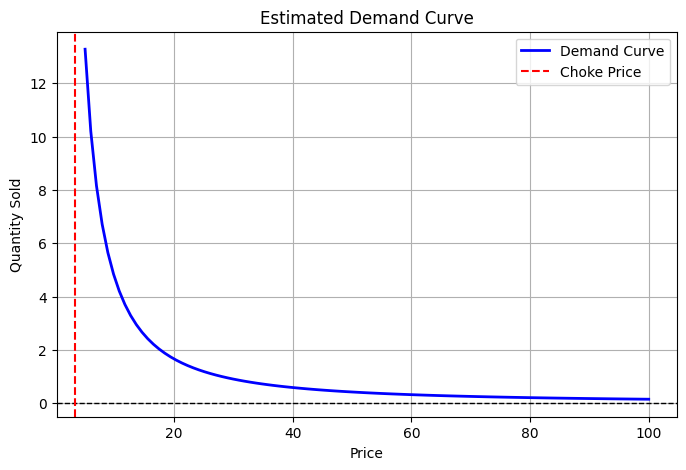

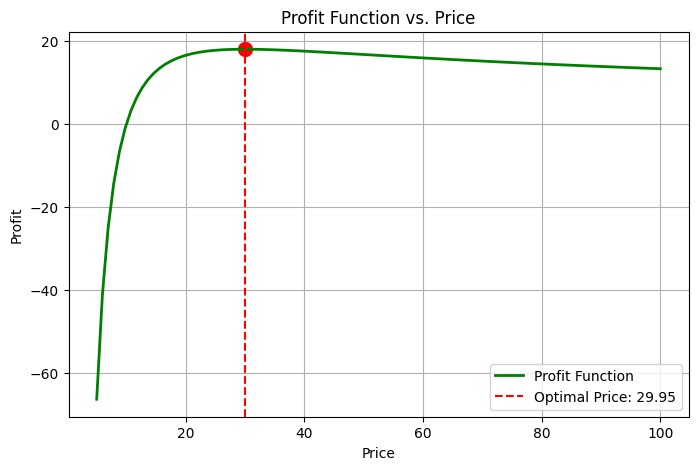

In [164]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated elasticity and intercept (from a model fit)
alpha = 5   # Intercept (log scale)
beta = -1.5 # Elasticity (negative slope)

# Generate price range
prices = np.linspace(5, 100, 100)  # Price range from 5 to 100

# Compute estimated demand
demand = np.exp(alpha + beta * np.log(prices))

# Plot the demand curve
plt.figure(figsize=(8, 5))
plt.plot(prices, demand, label="Demand Curve", color="blue", linewidth=2)

# Labels and title
plt.xlabel("Price")
plt.ylabel("Quantity Sold")
plt.title("Estimated Demand Curve")
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Zero demand line
plt.axvline(-alpha/beta, color='red', linestyle='--', label="Choke Price")  # When Q = 0
plt.legend()
plt.grid()

# Show the plot
plt.show()
import matplotlib.pyplot as plt
import numpy as np

# Simulated parameters (from an estimated model)
alpha = 5    # Intercept (log scale)
beta = -1.5  # Price elasticity
MC = 10      # Assumed marginal cost

# Generate a range of prices
prices = np.linspace(5, 100, 100)  # Price range from 5 to 100

# Compute demand function Q(P)
demand = np.exp(alpha + beta * np.log(prices))

# Compute profit function: Profit(P) = (P - MC) * Q(P)
profit = (prices - MC) * demand

# Find the optimal price where profit is maximized
optimal_price = prices[np.argmax(profit)]
max_profit = max(profit)

# Plot the profit function
plt.figure(figsize=(8, 5))
plt.plot(prices, profit, label="Profit Function", color="green", linewidth=2)

# Mark the optimal price
plt.axvline(optimal_price, color="red", linestyle="--", label=f"Optimal Price: {optimal_price:.2f}")
plt.scatter(optimal_price, max_profit, color="red", s=100)

# Labels and title
plt.xlabel("Price")
plt.ylabel("Profit")
plt.title("Profit Function vs. Price")
plt.legend()
plt.grid()

# Show the plot
plt.show()
